# Vežba 12 : Linearna regresija - Metode semplovanja, selekcija parametara i regularizacija

**Za potrebe reprodukovanja analize, treba instalirati paket ISLP (koji su kreirali autori knjige) u okruženje bio_ml!** Uputstvo za instaliranje, kao i podaci koji se koriste u knjizi su na [pratećem sajtu knjige](https://www.statlearning.com/resources-python). Iskoristite sledeće komande:

`conda activate bio_ml`

`pip install ISLP`

`pip install l0bnb`

`conda list ISLP`

**Praktikum reprodukuje primer** koda dat u poglavlju 3.6 "Lab: Linear Regression" u ISLP knjizi, sa idejom da se on iskoristi kao templejt za pisanje sličnog koda za analizu drugog seta podataka.

## Set podataka 

**abalone_dataset.csv** sadrži tabelu u kojoj se za svaku od 4177 jedinki školjke Petrovo uho (eng. abalone, Haliotis sp.) nalaze vrednosti 9 veličina kojima odgovaraju sledeći nazivi kolona:
1. `Length` (Longest shell measurement) in mm
2. `Diameter` (perpendicular to length) in mm
3. `Height` (with meat in shell) in mm
4. `Whole weight` (whole abalone) in grams
5. `Shucked weight` (weight of meat) in grams
6. `Viscera weight`	(gut weight after bleeding) in grams
7. `Shell weight` (after being dried) in grams
8. `Rings` (+1.5 gives the age in years) as integer values (celi brojevi)
9. `Sex` as categorical with values M (male), F (female), and I (infant)

Starost ovih školjki se određuje presecanjem ljušture i brojanjem prstenova na obojenom preseku pod mikroskopom. Ova kolekcija podataka je sastavljena sa ciljem da se ispita da li se druge karakteristike školjke koje je lakše izmeriti mogu iskoristiti za predviđanje broja prstenova, tj. starosti školjke.

## Cilj vežbe

Dati kod u sekcijama zadataka je anotiran sa njegovom funkcijom.

Neophodno je izmeniti i dopuniti postojeći kod kako bi radio sa abalone_dataset.csv setom podataka koji je opisan iznad.




## Zadatak 1 - Pristup validacionog skupa, Polinomska regresija i Unakrsna validacija (LOOCV, kFold)
U ovom zadatku vršimo podelu seta podataka na test i validacioni set i računamo MSE (srednju kvadratnu grešku) na validacionom setu podataka.

Nakon toga radimo regresiju za više modela sa polinomskim članom različitog stepena.

Na kraju radimo unakrsnu validaciju (Cross-Validation).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

# 1.1 Pristup validacionog skupa (The Validation Set Approach)
Neophodno je modifikovati set podataka na kome se radi. 

Zavisna varijabla (y_train, y_valid) treba da bude Rings kolona iz abalone_dataset.csv

Nezavisna varijabla treba da bude Shell weight kolona iz abalone_dataset.csv


In [2]:
abalone = pd.read_csv('abalone_dataset.csv')
print(abalone.shape)
abalone.head()

(4177, 9)


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Sex
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,M
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,M
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,F
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,M
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,I


In [3]:
abalone_train, abalone_valid = train_test_split(abalone, test_size=0.5, random_state=0)

x= MS(["Shell weight"])

X_train = x.fit_transform(abalone_train)
y_train = abalone_train["Rings"]

model = sm.OLS(y_train, X_train)
results = model.fit()

X_valid = x.transform(abalone_valid)
y_valid = abalone_valid['Rings']

valid_pred = results.predict(X_valid)

mse = np.mean((y_valid - valid_pred)**2)
print(">>>> MSE (Validacioni set - linearni):", mse)

>>>> MSE (Validacioni set - linearni): 6.300247226500096


In [4]:
# Učitavanje 'Auto' skupa podataka
#Auto = load_data('Auto')

# Podela podataka na trening i validacioni skup
# test_size=196 označava da 196 opservacija ide u validacioni skup
# random_state=0 osigurava ponovljivost rezultata pri svakom pokretanju
#Auto_train, Auto_valid = train_test_split(Auto, test_size=196, random_state=0)

# Prilagođavanje modela linearne regresije koristeći samo trening skup
# Kreiranje specifikacije modela za 'horsepower' (konjske snage)
#hp_mm = MS(['horsepower'])
# Transformacija trening podataka na osnovu specifikacije (dodaje presečnu tačku/intercept)
#X_train = hp_mm.fit_transform(Auto_train)
# Definisanje zavisne varijable (odziva) za trening ('mpg' - milja po galonu)
#y_train = Auto_train['mpg']
# Inicijalizacija OLS (Ordinary Least Squares) modela
#model = sm.OLS(y_train, X_train)
# Treniranje (fitovanje) modela na trening podacima
#results = model.fit()

# Evaluacija modela na validacionom skupu
# Transformacija validacionih podataka koristeći istu specifikaciju
#X_valid = hp_mm.transform(Auto_valid)
# Definisanje zavisne varijable za validaciju
#y_valid = Auto_valid['mpg']
# Generisanje predikcija za validacioni skup koristeći trenirani model
#valid_pred = results.predict(X_valid)

# Izračunavanje i ispisivanje srednje kvadratne greške (MSE)
# Računanje proseka kvadrata razlika između stvarnih i predviđenih vrednosti
#mse = np.mean((y_valid - valid_pred)**2)
# Ispisivanje rezultata MSE
#print("MSE (Validacioni set - linearni):", mse)

## 1.2 Polinomska regresija sa validacijom
Potrebno je adaptirati imena kolona u eval_mse funkciji kao i imena varijabli koje se prosleđuju ovoj funkciji. 

In [5]:

def eval_mse(degree, train, valid):
    
    mm = MS([poly('Shell weight', degree=degree)]) 
   
    X_train = mm.fit_transform(train)
    X_valid = mm.transform(valid)
    
    y_train = train['Rings']
    y_valid = valid['Rings']
    
    results = sm.OLS(y_train, X_train).fit()
    valid_pred = results.predict(X_valid)
    
    return np.mean((y_valid - valid_pred)**2)

mse_degree_1 = eval_mse(1, abalone_train, abalone_valid) # Linearni model
mse_degree_2 = eval_mse(2, abalone_train, abalone_valid) # Kvadratni model
mse_degree_3 = eval_mse(3, abalone_train, abalone_valid) # Kubni model

print(">>>> MSE vrednosti za stepene 1, 2 i 3:")
print(mse_degree_1)
print(mse_degree_2)
print(mse_degree_3)

>>>> MSE vrednosti za stepene 1, 2 i 3:
6.300247226500093
6.130704553496888
5.9884218537940725


In [6]:
# Funkcija za izračunavanje MSE za zadati stepen polinoma
#def eval_mse(degree, train, valid):
    # Kreiranje specifikacije modela sa polinomskim članom zadatog stepena
 #   mm = MS([poly('horsepower', degree=degree)]) 
      # Transformacija trening podataka
    #X_train = mm.fit_transform(train)
    # Transformacija validacionih podataka
    #X_valid = mm.transform(valid)
    # Izdvajanje zavisne varijable za trening
    #y_train = train['mpg']
    # Izdvajanje zavisne varijable za validaciju
    #y_valid = valid['mpg']
    
    # Treniranje OLS modela na trening podacima
    #results = sm.OLS(y_train, X_train).fit()
    # Predviđanje vrednosti na validacionom skupu
    # valid_pred = results.predict(X_valid)
    
    # Vraćanje izračunate srednje kvadratne greške (MSE)
    #return np.mean((y_valid - valid_pred)**2)

# Izračunavanje MSE za polinome stepena 1, 2 i 3
#mse_degree_1 = eval_mse(1, Auto_train, Auto_valid) # Linearni model
#mse_degree_2 = eval_mse(2, Auto_train, Auto_valid) # Kvadratni model
#mse_degree_3 = eval_mse(3, Auto_train, Auto_valid) # Kubni model

# Ispisivanje MSE vrednosti za poređenje
#print("MSE za stepene 1, 2, 3:", mse_degree_1, mse_degree_2, mse_degree_3)

## 1.3 Unakrsna validacija (Cross-Validation) 
Potrebno je adaptirati imena kolona koje se koriste za treniranje lineranog modela.

Zavisna varijabla (y_train, y_valid) treba da bude Rings kolona iz abalone_dataset.csv

Nezavisna varijabla treba da bude Shell weight kolona iz abalone_dataset.csv

In [7]:
x_model = MS(["Shell weight"])
X = x_model.fit_transform(abalone)

y = abalone['Rings']

model = LinearRegression()

cv = KFold(n_splits=len(X), shuffle=True, random_state=0)
cv_results = cross_validate(model, X, y, cv=cv, scoring='neg_mean_squared_error')

loocv_mse = -np.mean(cv_results['test_score'])
print('>>>> LOOCV MSE:', loocv_mse)

cv_10 = KFold(n_splits=10, shuffle=True, random_state=0)
cv_results_10 = cross_validate(model, X, y, cv=cv_10, scoring='neg_mean_squared_error')

kfold_mse = -np.mean(cv_results_10['test_score'])
print('>>>> 10-Fold CV MSE:', kfold_mse)

>>>> LOOCV MSE: 6.306480022647931
>>>> 10-Fold CV MSE: 6.308000765706209


In [8]:
# Priprema podataka za sklearn (koristeći ceo skup podataka jer CV radi podelu automatski)
#hp_model = MS(['horsepower'])
# Transformacija svih prediktora
#X = hp_model.fit_transform(Auto)
# Izdvajanje zavisne varijable iz celog skupa
#y = Auto['mpg']
# Inicijalizacija modela linearne regresije iz scikit-learn biblioteke
#model = LinearRegression()

# Unakrsna validacija "izostavi-jedan" (Leave-One-Out Cross-Validation - LOOCV)
# Koristimo KFold gde je broj podela (splits) jednak ukupnom broju opservacija
#cv = KFold(n_splits=len(X), shuffle=True, random_state=0)
# Izvođenje unakrsne validacije; scoring='neg_mean_squared_error' vraća negativni MSE
#cv_results = cross_validate(model, X, y, cv=cv, scoring='neg_mean_squared_error')
# Računanje prosečnog MSE (menjamo znak jer sklearn vraća negativne vrednosti)
#loocv_mse = -np.mean(cv_results['test_score'])
# Ispisivanje rezultata LOOCV
#print('LOOCV MSE:', loocv_mse)

# k-Fold unakrsna validacija (npr. k=10)
# Definisanje 10-struke podele (10-fold splitter)
#cv_10 = KFold(n_splits=10, shuffle=True, random_state=0)
# Izvođenje 10-struke unakrsne validacije
#cv_results_10 = cross_validate(model, X, y, cv=cv_10, scoring='neg_mean_squared_error')
# Računanje prosečnog MSE za 10-struku validaciju
#kfold_mse = -np.mean(cv_results_10['test_score'])
# Ispisivanje rezultata 10-Fold CV
#print('10-Fold CV MSE:', kfold_mse)

## Zadatak 2 - Selekcija nezavisnih prediktora (Forward selection)
U ovom zadatku vršimo selekciju nezavisnih prediktora na abalone_dataset.csv.

Potrebno je adaptirati kod da zavisna varijabla "Y" treba da bude "Rings" kolona iz abalone_dataset.csv dok sve preostale varijable iz abalone_dataset.csv (sem "Sex" kolone) trebaju da budu nezavisne varijable.

Za kriterijum selekcije prediktora prvo koristimo scoring="neg_mean_squared_error".

Zatim koristimo Mallows Cp kriterijum definisan u funkciji nCP.

Mallows Cp je kriterijum za izbor modela u linearnoj regresiji koji se koristi za biranje između konkurentskih modela tako što uravnotežuje kvalitet prilagođavanja (dobrotu uklapanja) i složenost modela. Njegova osnovna svrha je procena očekivane greške na test skupu bez eksplicitne upotrebe unakrsne validacije.




In [9]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from sklearn.preprocessing import StandardScaler

In [10]:
from l0bnb import fit_path

In [11]:
#Hitters = load_data('Hitters') # Učitavanje "Hitters" skupa podataka
#np.isnan(Hitters['Salary']).sum() # Računa ukupan broj nedostajućih vrednosti u koloni 'Salary'
#Hitters = Hitters.dropna() # Uklanja sve redove koji sadrže nedostajuće vrednosti
#Hitters.shape # Prikazuje dimenzije pročišćenog skupa podataka

In [12]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Y_estim = estimator.predict(X)
    RSS = np.sum((Y - Y_estim)**2)
    return -(RSS + 2 * p * sigma2) / n

In [13]:
#def nCp(sigma2, estimator, X, Y):
 #   "Negative Cp statistic"
 #   n, p = X.shape # Dobija broj uzoraka (n) i broj prediktora (p)
 #   Yhat = estimator.predict(X) # Generiše predviđanja na osnovu estimatora
 #   RSS = np.sum((Y - Yhat)**2) # Računa sumu kvadrata reziduala (RSS)
 #   return -(RSS + 2 * p * sigma2) / n # Vraća negativnu Cp statistiku (jer sklearn maksimizuje skor)

In [14]:
design = MS(abalone.columns.drop(["Rings", "Sex"])).fit(abalone)

Y = np.array(abalone['Rings']) 
X = design.transform(abalone)

sigma2 = OLS(Y,X).fit().scale

In [15]:
#design = MS(Hitters.columns.drop('Salary')).fit(Hitters) # Kreira dizajn matricu isključujući ciljnu promenljivu 'Salary'
#Y = np.array(Hitters['Salary']) # Izdvaja ciljnu promenljivu Y kao niz
#X = design.transform(Hitters) # Transformiše podatke u matricu prediktora X
#sigma2 = OLS(Y,X).fit().scale # Prilagođava OLS model na svim podacima da bi se procenila varijansa šuma (sigma2)

In [16]:
neg_Cp = partial(nCp, sigma2)

In [17]:
#neg_Cp = partial(nCp, sigma2) # Kreira novu funkciju skorovanja sa fiksiranim parametrom sigma2 (procenjena varijansa šuma)

In [18]:
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

In [19]:
#strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms)) 
# Definiše strategiju postupnog izbora (forward selection) koja staje na prvom piku

In [20]:
abalone_MSE = sklearn_selected(OLS, strategy, scoring="neg_mean_squared_error")
abalone_MSE.fit(abalone, Y)

print(">>>> Izabrane promenljive prema Cp kriterijumu:")
abalone_MSE.selected_state_

>>>> Izabrane promenljive prema Cp kriterijumu:


('Diameter',
 'Height',
 'Length',
 'Shell weight',
 'Shucked weight',
 'Viscera weight',
 'Whole weight')

In [21]:
#hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp) # Inicijalizuje selektor modela koristeći negativni Cp kao kriterijum
#hitters_Cp.fit(Hitters, Y) # Pokreće proces selekcije
#hitters_Cp.selected_state_ # Prikazuje izabrane promenljive prema Cp kriterijumu

## Zadatak 3 - Ridge i Lasso regresija - optimizacija lambda parametra sa unakrsnom validacijom

Potrebno je adaptirati kod da zavisna varijabla "Y" treba da bude "Rings" kolona iz abalone_dataset.csv dok sve preostale varijable iz abalone_dataset.csv (sem "Sex" kolone) trebaju da budu nezavisne varijable.

In [22]:
D = design.fit_transform(abalone)

X = np.asarray(D)

scaler = StandardScaler(with_mean=True, with_std=True)
X_s = scaler.fit_transform(X)

lambdas = 10**np.linspace(8, -2, 100) / Y.std()
solutions = skl.ElasticNet.path(X_s, Y, l1_ratio=0, alphas=lambdas)[1]

print(">>>> Dimenzije rešenja:")
solutions.shape

>>>> Dimenzije rešenja:


(8, 100)

In [23]:
#D = design.fit_transform(Hitters) # Priprema dizajn matricu
#X = np.asarray(D) 
#scaler = StandardScaler(with_mean=True, with_std=True) # Skaliranje ulaynih podataka
#X_s = scaler.fit_transform(X)
#lambdas = 10**np.linspace(8, -2, 100) / Y.std() # Generiše niz lambda vrednosti (hiperparametara) skaliranih devijacijom Y
#soln_array = skl.ElasticNet.path(X_s, Y, l1_ratio=0, alphas=lambdas)[1] # Računa putanju rešenja za Ridge regresiju (l1_ratio=0)
#soln_array.shape # Prikazuje dimenzije rešenja

In [24]:
coefs = pd.DataFrame(solutions.T, columns=D.columns, index=-np.log(lambdas))
coefs.index.name = "negative log(lambda)"
coefs

,intercept,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
negative log(lambda),,,,,,,,
-17.250125,0.0,5.785861e-08,5.972311e-08,5.793633e-08,5.616148e-08,4.374149e-08,5.236080e-08,6.522236e-08
-17.017541,0.0,7.300929e-08,7.536201e-08,7.310735e-08,7.086775e-08,5.519550e-08,6.607183e-08,8.230128e-08
-16.784957,0.0,9.212726e-08,9.509606e-08,9.225101e-08,8.942495e-08,6.964881e-08,8.337319e-08,1.038524e-07
-16.552372,0.0,1.162514e-07,1.199976e-07,1.164076e-07,1.128415e-07,8.788682e-08,1.052050e-07,1.310469e-07
-16.319788,0.0,1.466926e-07,1.514198e-07,1.468897e-07,1.423898e-07,1.109006e-07,1.327537e-07,1.653624e-07
...,...,...,...,...,...,...,...,...
4.845388,0.0,1.369162e-02,1.077650e+00,5.200418e-01,2.068498e+00,-3.229946e+00,-5.191937e-01,1.940834e+00
5.077973,0.0,-1.664909e-02,1.114743e+00,5.156116e-01,2.331994e+00,-3.380353e+00,-5.769253e-01,1.875107e+00
5.310557,0.0,-4.420196e-02,1.148260e+00,5.118512e-01,2.593823e+00,-3.523393e+00,-6.349310e-01,1.804105e+00


In [25]:
#soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas)) # Kreira DataFrame sa koeficijentima za lakše plotovanje
#soln_path.index.name = 'negative log(lambda)' # Imenuje indeks DataFrame-a
#soln_path # Prikazuje DataFrame

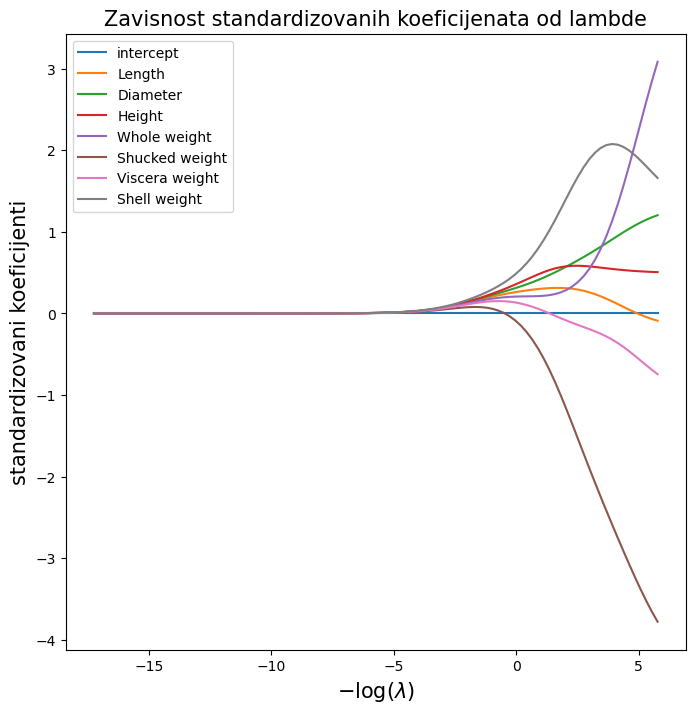

In [26]:
path_fig, ax = subplots(figsize=(8,8))
coefs.plot(ax=ax, legend=False)

ax.set_xlabel(r"$-\log(\lambda)$", fontsize=15)
ax.set_ylabel("standardizovani koeficijenti", fontsize=15)

ax.set_title("Zavisnost standardizovanih koeficijenata od lambde", fontsize=15)
ax.legend(loc='upper left')

plt.suptitle('');

In [27]:
#path_fig, ax = subplots(figsize=(8,8)) # Kreira figuru za grafik
#soln_path.plot(ax=ax, legend=False) # Iscrtava promene koeficijenata u zavisnosti od lambde
#ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Postavlja oznaku x-ose (koristi LaTeX formatiranje)
#ax.set_ylabel('Standardized coefficients', fontsize=20) # Postavlja oznaku y-ose
#ax.legend(loc='upper left') # Postavlja legendu u gornji levi ugao

In [28]:
beta_estim =coefs.loc[coefs.index[39]]

print(">>>> Koeficijenti za 40. korak:")
lambdas[39], beta_estim

>>>> Koeficijenti za 40. korak:


(np.float64(3566.483761229299),
 intercept         0.000000
 Length            0.000502
 Diameter          0.000519
 Height            0.000503
 Whole weight      0.000488
 Shucked weight    0.000380
 Viscera weight    0.000455
 Shell weight      0.000566
 Name: -8.1793354485686, dtype: float64)

In [29]:
#beta_hat = soln_path.loc[soln_path.index[39]] # Izdvaja koeficijente za 40-ti korak
#lambdas[39], beta_hat # Prikazuje lambda vrednost i koeficijente tog koraka

In [30]:
print(">>>> L2 norma koeficijenta:")
np.linalg.norm(beta_estim)

>>>> L2 norma koeficijenta:


np.float64(0.0012975244983926594)

In [31]:
#np.linalg.norm(beta_hat) # Računa L2 normu koeficijenata za izabrani model

In [32]:
beta_estim= coefs.loc[coefs.index[59]]

print(">>>> Koeficijenti za 60. korak:")
lambdas[59], np.linalg.norm(beta_estim)

>>>> Koeficijenti za 60. korak:


(np.float64(34.04381569990923), np.float64(0.1150555350597277))

In [33]:
#beta_hat = soln_path.loc[soln_path.index[59]] # Izdvaja koeficijente za 60-ti korak (manja lambda)
#lambdas[59], np.linalg.norm(beta_hat) # Prikazuje lambda vrednost i veću L2 normu

In [34]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0) 

scaler = StandardScaler(with_mean=True, with_std=True) 

pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('ridge', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: float, default=1.0Constant that multiplies the penalty terms. Defaults to 1.0.See the notes for the exact mathematical meaning of thisparameter. ``alpha = 0`` is equivalent to an ordinary least square,solved by the :class:`LinearRegression` object. For numericalreasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.Given this, you should use the :class:`LinearRegression` object.",np.float64(34.04381569990923)
,"l1_ratio l1_ratio: float, default=0.5The ElasticNet mixing parameter, with ``0 <= l1_ratio <= 1``. For``l1_ratio = 0`` the penalty is an L2 penalty. ``For l1_ratio = 1`` itis an L1 penalty. For ``0 < l1_ratio < 1``, the penalty is acombination of L1 and L2.",0
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If ``False``, thedata is assumed to be already centered.",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.Check :ref:`an example on how to use a precomputed Gram Matrix in ElasticNet`for details.",False


In [35]:
#ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0) # Inicijalizuje Ridge model sa specifičnom lambdom
#scaler = StandardScaler(with_mean=True, with_std=True) # Inicijalizuje skaler za standardizaciju podataka
#pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)]) # Kreira pajplajn koji prvo skalira pa primenjuje Ridge
#pipe.fit(X, Y) # Trenira pajplajn na podacima

In [36]:
print(">>>> L2 norma koeficijenata iz pajplajna:")
np.linalg.norm(ridge.coef_)

>>>> L2 norma koeficijenata iz pajplajna:


np.float64(0.11505553505972767)

In [37]:
#np.linalg.norm(ridge.coef_) # Proverava L2 normu koeficijenata iz pajplajna (treba da se poklapa)

In [38]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

ridge.alpha = 0.01

results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error', cv=validation)
print(">>>> Pozitivan MSE:")
-results['test_score']

>>>> Pozitivan MSE:


array([6.24716562])

In [39]:
#validation = skm.ShuffleSplit(n_splits=1, test_size=0.5, random_state=0) # Kreira validacioni split (50/50)
#ridge.alpha = 0.01 # Postavlja proizvoljnu vrednost za lambda (alpha)
#results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error', cv=validation) # Izvršava validaciju i računa negativni MSE
#-results['test_score'] # Prikazuje pozitivan MSE

In [40]:
ridge.alpha = 1e10 

results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error', cv=validation)
print(">>>> MSE:")
-results['test_score']

>>>> MSE:


array([10.38007843])

In [41]:
#ridge.alpha = 1e10 # Postavlja ogromnu vrednost za lambda (teži ka nultom modelu)
#results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error', cv=validation) # Izvršava validaciju
#-results['test_score'] # Prikazuje MSE (koji bi trebao biti sličan varijansi Y)

In [42]:
param_grid = {'ridge__alpha': lambdas} 
grid = skm.GridSearchCV(pipe, param_grid, cv=validation, scoring='neg_mean_squared_error')
grid.fit(X, Y)

grid.best_params_['ridge__alpha']
print(">>>> Najbolji estimator:")
print(" ")
grid.best_estimator_

>>>> Najbolji estimator:
 


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('ridge', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: float, default=1.0Constant that multiplies the penalty terms. Defaults to 1.0.See the notes for the exact mathematical meaning of thisparameter. ``alpha = 0`` is equivalent to an ordinary least square,solved by the :class:`LinearRegression` object. For numericalreasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.Given this, you should use the :class:`LinearRegression` object.",np.float64(0....1945694181704)
,"l1_ratio l1_ratio: float, default=0.5The ElasticNet mixing parameter, with ``0 <= l1_ratio <= 1``. For``l1_ratio = 0`` the penalty is an L2 penalty. ``For l1_ratio = 1`` itis an L1 penalty. For ``0 < l1_ratio < 1``, the penalty is acombination of L1 and L2.",0
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If ``False``, thedata is assumed to be already centered.",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.Check :ref:`an example on how to use a precomputed Gram Matrix in ElasticNet`for details.",False


In [43]:
#param_grid = {'ridge__alpha': lambdas} # Definiše mrežu parametara za pretragu (lambdas)
#grid = skm.GridSearchCV(pipe, param_grid, cv=validation, scoring='neg_mean_squared_error') # Inicijalizuje pretragu na mreži (Grid Search) sa validacionim setom
#grid.fit(X, Y) # Pokreće pretragu da nađe najbolju lambdu
#grid.best_params_['ridge__alpha'] # Prikazuje najbolju pronađenu vrednost za lambda
#grid.best_estimator_ # Prikazuje najbolji estimator (ceo pajplajn)

In [44]:
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)

grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)

grid.best_params_['ridge__alpha']
print(">>>> Najbolji estimator:")
print(" ")
grid.best_estimator_

>>>> Najbolji estimator:
 


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('ridge', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: float, default=1.0Constant that multiplies the penalty terms. Defaults to 1.0.See the notes for the exact mathematical meaning of thisparameter. ``alpha = 0`` is equivalent to an ordinary least square,solved by the :class:`LinearRegression` object. For numericalreasons, using ``alpha = 0`` with the ``Lasso`` object is not advised.Given this, you should use the :class:`LinearRegression` object.",np.float64(0....1945694181704)
,"l1_ratio l1_ratio: float, default=0.5The ElasticNet mixing parameter, with ``0 <= l1_ratio <= 1``. For``l1_ratio = 0`` the penalty is an L2 penalty. ``For l1_ratio = 1`` itis an L1 penalty. For ``0 < l1_ratio < 1``, the penalty is acombination of L1 and L2.",0
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If ``False``, thedata is assumed to be already centered.",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.Check :ref:`an example on how to use a precomputed Gram Matrix in ElasticNet`for details.",False


In [45]:
#K = 5
#kfold = skm.KFold(K,
#random_state=0,
#shuffle=True)

#grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error') # Inicijalizuje Grid Search koristeći 5-fold unakrsnu validaciju
#grid.fit(X, Y) # Pokreće pretragu
#grid.best_params_['ridge__alpha'] # Prikazuje najbolju lambdu prema CV
#grid.best_estimator_ # Prikazuje najbolji estimator

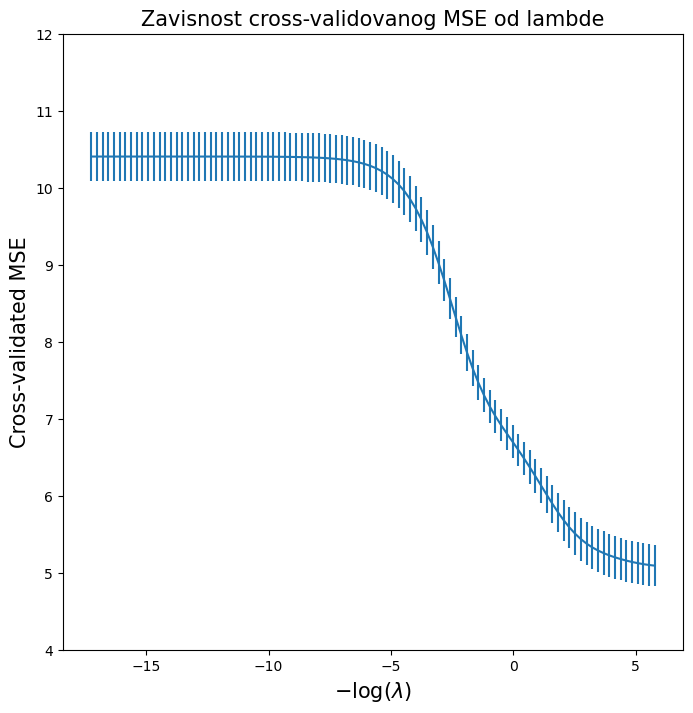

In [46]:
ridge_fig, ax = subplots(figsize=(8,8))

ax.errorbar(-np.log(lambdas), -grid.cv_results_['mean_test_score'], yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([4, 12])

ax.set_xlabel(r"$-\log(\lambda)$", fontsize=15)
ax.set_ylabel('Cross-validated MSE', fontsize=15)

ax.set_title("Zavisnost cross-validovanog MSE od lambde", fontsize=15)

plt.suptitle('');

In [47]:
#ridge_fig, ax = subplots(figsize=(8,8)) # Kreira figuru
#ax.errorbar(-np.log(lambdas), -grid.cv_results_['mean_test_score'], yerr=grid.cv_results_['std_test_score'] / np.sqrt(K)) # Iscrtava CV greške sa standardnim greškama
#ax.set_ylim([50000, 250000]) # Postavlja limite y-ose
#ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Postavlja oznaku x-ose
#ax.set_ylabel('Cross-validated MSE', fontsize=20) # Postavlja oznaku y-ose

In [48]:
grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold)
grid_r2.fit(X, Y)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...l1_ratio=0))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.",{'ridge__alpha': array([3.1019...10194569e-03])}
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",KFold(n_split... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is al

In [49]:
#grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold) # Inicijalizuje Grid Search koristeći podrazumevani R2 skor
#grid_r2.fit(X, Y) # Pokreće pretragu

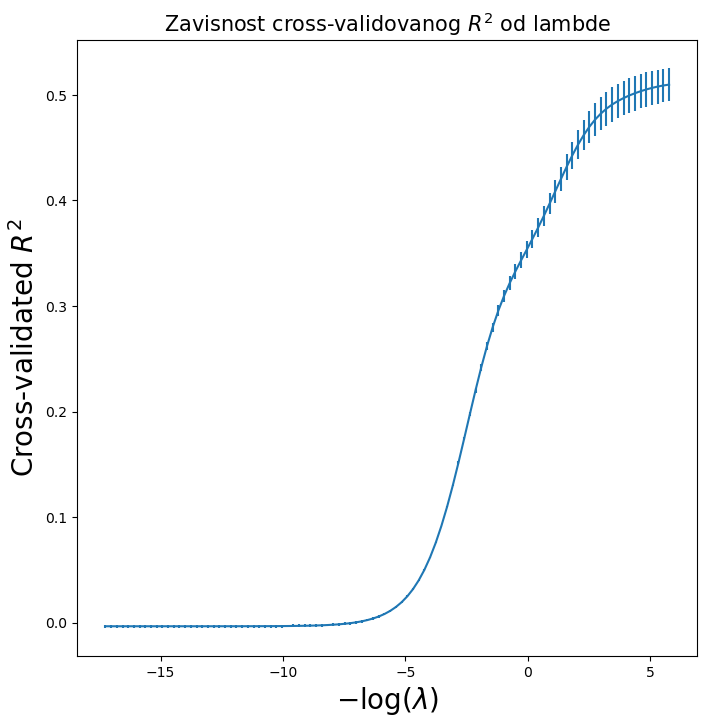

In [50]:
r2_fig, ax = subplots(figsize=(8,8))

ax.errorbar(-np.log(lambdas), grid_r2.cv_results_['mean_test_score'], yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)) 

ax.set_xlabel(r"$-\log(\lambda)$", fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20)

ax.set_title("Zavisnost cross-validovanog $R^2$ od lambde", fontsize=15)
plt.suptitle=(" ")

In [51]:
#r2_fig, ax = subplots(figsize=(8,8)) # Kreira figuru za R2 grafik
#ax.errorbar(-np.log(lambdas), grid_r2.cv_results_['mean_test_score'], yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)) # Iscrtava R2 skorove
#ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Oznaka x-ose
#ax.set_ylabel('Cross-validated $R^2$', fontsize=20) # Oznaka y-ose

In [52]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('ridge', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"l1_ratio l1_ratio: float or list of float, default=0.5Float between 0 and 1 passed to ElasticNet (scaling betweenl1 and l2 penalties). For ``l1_ratio = 0``the penalty is an L2 penalty. For ``l1_ratio = 1`` it is an L1 penalty.For ``0 < l1_ratio < 1``, the penalty is a combination of L1 and L2This parameter can be a list, in which case the differentvalues are tested by cross-validation and the one giving the bestprediction score is used. Note that a good choice of list ofvalues for l1_ratio is often to put more values close to 1(i.e. Lasso) and less close to 0 (i.e. Ridge), as in ``[.1, .5, .7,.9, .95, .99, 1]``.",0
,"eps eps: float, default=1e-3Length of the path. ``eps=1e-3`` means that``alpha_min / alpha_max = 1e-3``.",0.001
,"n_alphas n_alphas: int, default=100Number of alphas along the regularization path, used for each l1_ratio... deprecated:: 1.7 `n_alphas` was deprecated in 1.7 and will be removed in 1.9. Use `alphas` instead.",'deprecated'
,"alphas alphas: array-like or int, default=NoneValues of alphas to test along the regularization path, used for each l1_ratio.If int, `alphas` values are generated automatically.If array-like, list of alpha values to use... versionchanged:: 1.7 `alphas` accepts an integer value which removes the need to pass `n_alphas`... deprecated:: 1.7 `alphas=None` was deprecated in 1.7 and will be removed in 1.9, at which point the default value will be set to 100.",array([3.1019...10194569e-03])


In [53]:
#ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold) # Koristi efikasniju ugrađenu CV funkciju za Ridge
#pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)]) # Pravi pajplajn sa RidgeCV
#pipeCV.fit(X, Y) # Trenira pajplajn

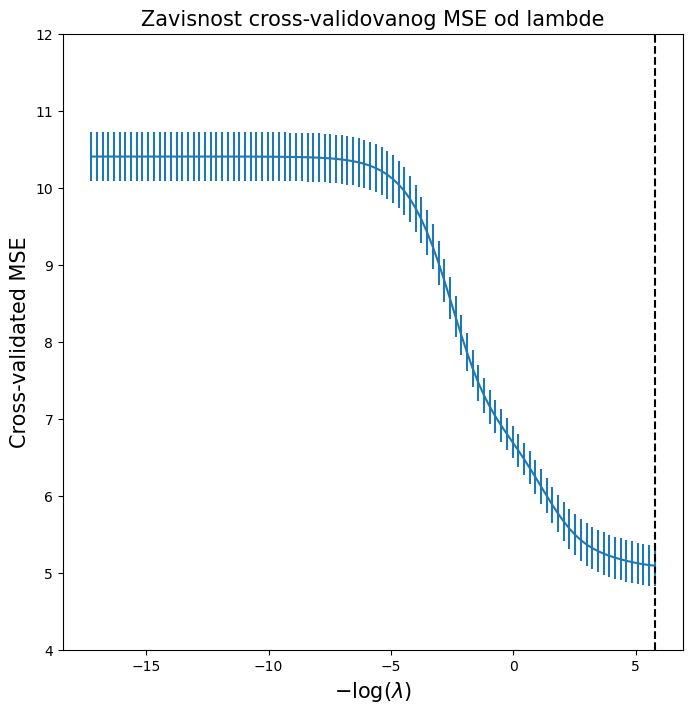

In [54]:
tuned_ridge = pipeCV.named_steps['ridge']

ridgeCV_fig, ax = subplots(figsize=(8,8))

ax.errorbar(-np.log(lambdas), tuned_ridge.mse_path_.mean(1), yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')

ax.set_ylim([4, 12])

ax.set_xlabel(r'$-\log(\lambda)$', fontsize=15)
ax.set_ylabel('Cross-validated MSE', fontsize=15)

ax.set_title("Zavisnost cross-validovanog MSE od lambde", fontsize=15)
plt.suptitle=(" ")

In [55]:
#tuned_ridge = pipeCV.named_steps['ridge'] # Izdvaja istrenirani Ridge model iz pajplajna
#ridgeCV_fig, ax = subplots(figsize=(8,8)) # Kreira figuru
#ax.errorbar(-np.log(lambdas), tuned_ridge.mse_path_.mean(1), yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K)) # Iscrtava putanju MSE grešaka
#ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--') # Označava vertikalnom linijom izabranu optimalnu lambdu
#ax.set_ylim([50000, 250000]) # Limiti y-ose
#ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Oznaka x-ose
#ax.set_ylabel('Cross-validated MSE', fontsize=20) # Oznaka y-ose

In [56]:
print(">>> Minimalna srednja MSE vrednost sa putanje:")
np.min(tuned_ridge.mse_path_.mean(1))

>>> Minimalna srednja MSE vrednost sa putanje:


np.float64(5.090854084712589)

In [57]:
#np.min(tuned_ridge.mse_path_.mean(1)) # Prikazuje minimalnu srednju MSE vrednost sa putanje

In [58]:
print(">>> Koeficijenti modela za optimalnu lambdu:")
tuned_ridge.coef_

>>> Koeficijenti modela za optimalnu lambdu:


array([ 0.        , -0.08985245,  1.20372208,  0.50605515,  3.08565597,
       -3.78001905, -0.74528759,  1.66016639])

In [59]:
#tuned_ridge.coef_ # Prikazuje koeficijente modela za optimalnu lambdu (svi su različiti od nule kod Ridge-a)

In [60]:
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)

inner_cv = skm.KFold(n_splits=5, shuffle=True, random_state=2) 
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv) 

pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)]) 

results = skm.cross_validate(pipeCV, X, Y, cv=outer_valid, scoring='neg_mean_squared_error') 
print(">>> MSE:")
-results['test_score']

>>> MSE:


array([4.90158962])

In [61]:
#outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1) # Definisanje spoljašnjeg validacionog splita
#inner_cv = skm.KFold(n_splits=5, shuffle=True, random_state=2) # Definisanje unutrašnje CV petlje
#ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv) # Definisanje modela sa unutrašnjom CV
#pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)]) # Kreiranje pajplajna
#results = skm.cross_validate(pipeCV, X, Y, cv=outer_valid, scoring='neg_mean_squared_error') # Izvršavanje ugnježdene validacije
#-results['test_score'] # Prikaz rezultujućeg MSE-a

In [62]:
lassoCV = skl.ElasticNetCV(alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])

pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']

print(">>> Optimalna lambda za Lasso:")
tuned_lasso.alpha_

>>> Optimalna lambda za Lasso:


np.float64(0.002023162577241302)

In [63]:
#lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold) # Inicijalizuje CV za Lasso (l1_ratio=1)
#pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)]) # Kreira pajplajn za Lasso
#pipeCV.fit(X, Y) # Trenira Lasso model
#tuned_lasso = pipeCV.named_steps['lasso'] # Izdvaja Lasso model
#tuned_lasso.alpha_ # Prikazuje optimalnu lambdu za Lasso

In [64]:
lambdas, solutions = skl.Lasso.path(X_s, Y, l1_ratio=1, n_alphas=100)[:2]
coefs = pd.DataFrame(solutions.T, columns=D.columns, index=-np.log(lambdas))

In [65]:
#lambdas, soln_array = skl.Lasso.path(X_s, Y, l1_ratio=1, n_alphas=100)[:2] # Računa putanju rešenja za Lasso
#soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas)) # Kreira DataFrame koeficijenata

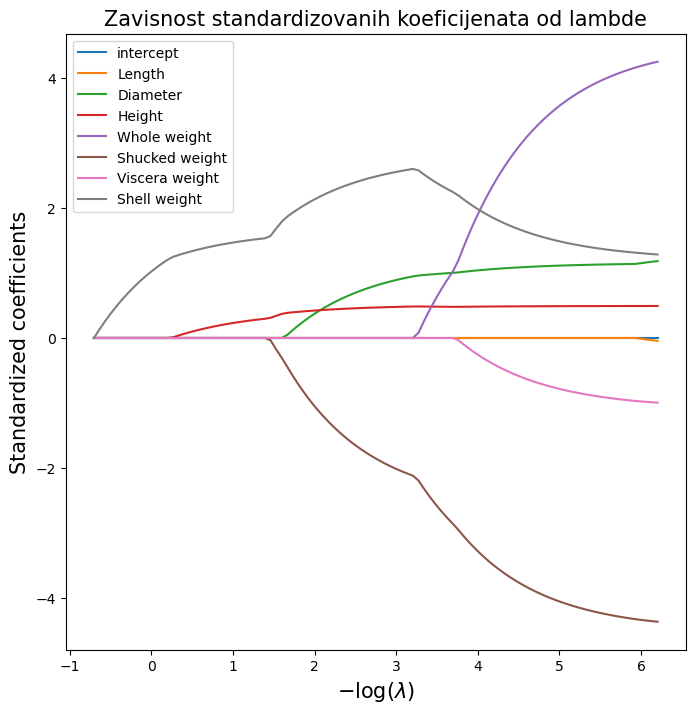

In [66]:
path_fig, ax = subplots(figsize=(8,8)) 

coefs.plot(ax=ax, legend=False)

ax.legend(loc='upper left')

ax.set_xlabel(r'$-\log(\lambda)$', fontsize=15)
ax.set_ylabel('Standardized coefficients', fontsize=15)

ax.set_title("Zavisnost standardizovanih koeficijenata od lambde", fontsize=15)
plt.suptitle=(" ")

In [67]:
#path_fig, ax = subplots(figsize=(8,8)) # Kreira figuru
#soln_path.plot(ax=ax, legend=False) # Iscrtava Lasso putanju
#ax.legend(loc='upper left') # Legenda
#ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Oznaka x-ose
#ax.set_ylabel('Standardized coefficients', fontsize=20) # Oznaka y-ose

In [68]:
print (">>> Minimalni MSE za Lasso:")
np.min(tuned_lasso.mse_path_.mean(1))

>>> Minimalni MSE za Lasso:


np.float64(5.065591812694349)

In [69]:
#np.min(tuned_lasso.mse_path_.mean(1)) # Prikazuje minimalni MSE za Lasso

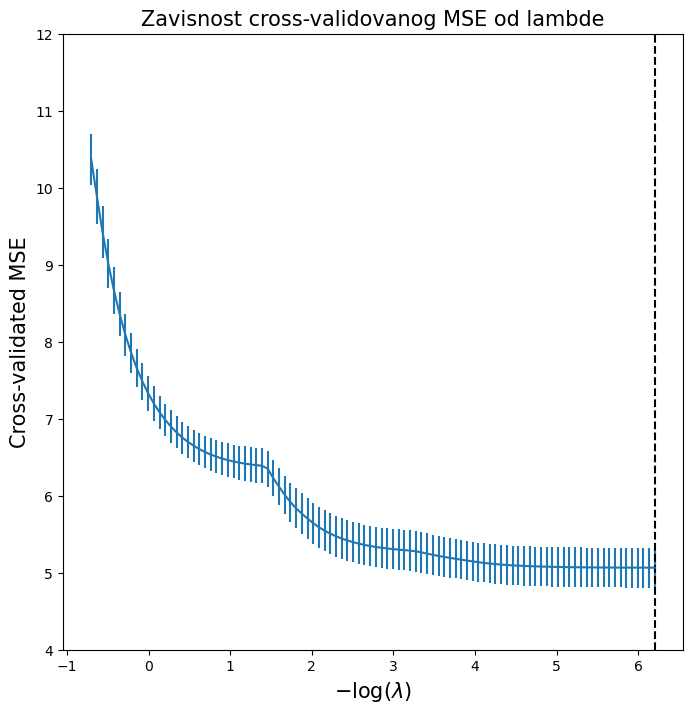

In [70]:
lassoCV_fig, ax = subplots(figsize=(8,8)) # Kreira figuru za CV grešku Lasso-a

ax.errorbar(-np.log(tuned_lasso.alphas_), tuned_lasso.mse_path_.mean(1), yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))

ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')

ax.set_ylim([4, 12])

ax.set_xlabel(r'$-\log(\lambda)$', fontsize=15)
ax.set_ylabel('Cross-validated MSE', fontsize=15)

ax.set_title("Zavisnost cross-validovanog MSE od lambde", fontsize=15)
plt.suptitle=(" ")

In [71]:
#lassoCV_fig, ax = subplots(figsize=(8,8)) # Kreira figuru za CV grešku Lasso-a
#ax.errorbar(-np.log(tuned_lasso.alphas_), tuned_lasso.mse_path_.mean(1), yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K)) # Iscrtava greške
#ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--') # Označava optimalnu lambdu
#ax.set_ylim([50000, 250000]) # Limiti y-ose
#ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Oznaka x-ose
#ax.set_ylabel('Cross-validated MSE', fontsize=20) # Oznaka y-ose

In [72]:
print(">>> Koeficijenti Lasso modela:")
tuned_lasso.coef_

>>> Koeficijenti Lasso modela:


array([ 0.        , -0.04480179,  1.18238304,  0.49220871,  4.24570694,
       -4.36081118, -0.99389501,  1.28349297])

In [73]:
#tuned_lasso.coef_ # Prikazuje koeficijente Lasso modela (mnogi su nula - sparse model)